In [1]:
import numpy as np
import xarray as xr

from ocr.conus404 import (
    compute_modal_wind_direction,
    compute_relative_humidity,
    compute_wind_speed_and_direction,
    geo_sel,
    load_conus404,
    rotate_winds_to_earth,
)

In [2]:
from distributed import Client

In [3]:
client = Client()

In [4]:
ds = load_conus404(add_spatial_constants=True)

In [5]:
# ds = geo_sel(ds, bbox=(-120.364, 47.387, -120.256, 47.460))
# ds = geo_sel(ds, bbox=(-119, 48, -118.5, 47.5))
# ds = geo_sel(ds, bbox=(-122, 49, -119.5, 48)) # washington
ds = geo_sel(ds, bbox=(-122, 40, -120, 39))  # paradise

ds

<xarray.Dataset> Size: 16GB
Dimensions:   (time: 376945, y: 37, x: 48)
Coordinates:
  * x         (x) float64 384B -2.024e+06 -2.02e+06 ... -1.84e+06 -1.836e+06
  * time      (time) datetime64[ns] 3MB 1979-10-01 ... 2022-10-01
  * y         (y) float64 296B 2.24e+05 2.28e+05 2.32e+05 ... 3.64e+05 3.68e+05
    crs       int64 8B ...
    lat       (y, x) float32 7kB dask.array<chunksize=(7, 3), meta=np.ndarray>
    lon       (y, x) float32 7kB dask.array<chunksize=(7, 3), meta=np.ndarray>
Data variables:
    PSFC      (time, y, x) float32 3GB dask.array<chunksize=(376945, 7, 3), meta=np.ndarray>
    Q2        (time, y, x) float32 3GB dask.array<chunksize=(376945, 7, 3), meta=np.ndarray>
    T2        (time, y, x) float32 3GB dask.array<chunksize=(376945, 7, 3), meta=np.ndarray>
    TD2       (time, y, x) float32 3GB dask.array<chunksize=(376945, 7, 3), meta=np.ndarray>
    U10       (time, y, x) float32 3GB dask.array<chunksize=(376945, 7, 3), meta=np.ndarray>
    V10       (time, y, x) float32 3GB dask.array<chunksize=(376945, 7, 3), meta=np.ndarray>
    SINALPHA  (y, x) float32 7kB dask.array<chunksize=(37, 48), meta=np.ndarray>
    COSALPHA  (y, x) float32 7kB dask.array<chunksize=(37, 48), meta=np.ndarray>
Attributes: (12/148)
    AER_ANGEXP_OPT:                  1
    AER_ANGEXP_VAL:                  1.2999999523162842
    AER_AOD550_OPT:                  1
    AER_AOD550_VAL:                  0.11999999731779099
    AER_ASY_OPT:                     1
    AER_ASY_VAL:                     0.8999999761581421
    ...                              ...
    WEST-EAST_PATCH_START_STAG:      1
    WEST-EAST_PATCH_START_UNSTAG:    1
    W_DAMPING:                       1
    YSU_TOPDOWN_PBLMIX:              0
    history:                         Tue Mar 29 16:35:22 2022: ncrcat -A -vW ...
    history_of_appended_files:       Tue Mar 29 16:35:22 2022: Appended file ...

In [6]:
hurs = compute_relative_humidity(ds)
earth_u, earth_v = rotate_winds_to_earth(ds)
wind_ds = compute_wind_speed_and_direction(earth_u, earth_v)

# hurs_threshold = 15
# wind_threshold = 35
# fire_weather_mask = build_fire_weather_mask(
#     hurs,
#     wind_ds,
#     hurs_threshold=hurs_threshold,
#     wind_threshold=wind_threshold,
# )

/opt/coiled/env/lib/python3.13/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])
/opt/coiled/env/lib/python3.13/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


In [7]:
ds['hurs'] = hurs

In [8]:
ds['sfcWind'] = wind_ds.sfcWind

In [9]:
# convert to fahrenheit
ds['T2'] = (ds.T2 - 273.15) * 1.8 + 32

# Updates to-do
- (1) swap in: create mask by (1) calculating FFWI instead of the temp/humidity thresholds and then (2) taking a percentile (see bullet point below) -> run for CONUS (using 0.99 and 0.95?), save the `ffwi_da` so that it's easy to do other quantiles or re-access the ffwi values
- (2) extract distribution, not just mode (at some point it was in there, get it back)


In [11]:
def ffwi(hurs, T2, sfcWind):
    # taken from https://wikifire.wsl.ch/tiki-indexb1d5.html?page=Fosberg+fire+weather+index&structure=Fire
    # hurs, T2, sfcWind are arrays or scalars
    emc = np.where(
        hurs <= 10,
        0.03229 + 0.281073 * hurs - 0.000578 * hurs * T2,
        np.where(
            (hurs > 10) & (hurs <= 50),
            2.22749 + 0.160107 * hurs - 0.01478 * T2,
            np.where(
                (hurs > 50) & (hurs <= 100),
                21.0606 + 0.005565 * hurs**2 - 0.00035 * hurs * T2 - 0.483199 * hurs,
                np.nan,
            ),
        ),
    )
    nu = 1 - 2 * (emc / 30) + 1.5 * ((emc / 30) ** 2) - 0.5 * ((emc / 30) ** 3)
    ffwi = nu * np.sqrt(1 + (sfcWind**2))
    return ffwi


# Apply to your dataset
ffwi_da = xr.apply_ufunc(
    ffwi,
    ds['hurs'],
    ds['T2'],
    ds['sfcWind'],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float],
)

In [12]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://cluster-jmfpy.dask.host/jupyter/proxy/8787/status,
Dashboard: https://cluster-jmfpy.dask.host/jupyter/proxy/8787/status,Workers: 8
Total threads: 32,Total memory: 122.82 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34083,Workers: 0
Dashboard: https://cluster-jmfpy.dask.host/jupyter/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:36147,Total threads: 4
Dashboard: https://cluster-jmfpy.dask.host/jupyter/proxy/44991/status,Memory: 15.35 GiB
Nanny: tcp://127.0.0.1:46557,


In [13]:
fire_weather_mask = ffwi_da > ffwi_da.quantile(0.95, dim='time')

In [14]:
%%time
mode = compute_modal_wind_direction(wind_ds['sfcWindfromdir'], fire_weather_mask).compute()

/opt/coiled/env/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
/opt/coiled/env/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/opt/coiled/env/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in log
  return self.func(*new_argspec)
/opt/coiled/env/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/opt/coiled/env/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in add
  return self.func(*new_argspec)
/opt/coiled/env/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in add
  return self.func(*new_argspec)
/opt/coiled/env/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning:

CPU times: user 2min 46s, sys: 25 s, total: 3min 11s
Wall time: 30min 15s


In [15]:
mode.to_zarr('s3://carbonplan-ocr/evaluation/ca_paradise_mode_fwi95p.zarr')

/opt/coiled/env/lib/python3.13/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


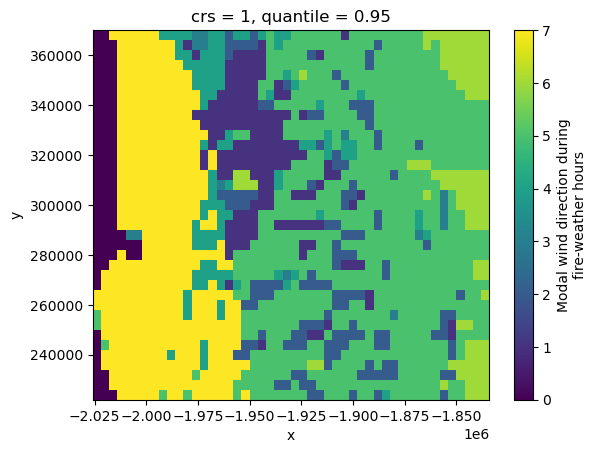

In [16]:
mode.wind_direction_mode.plot()

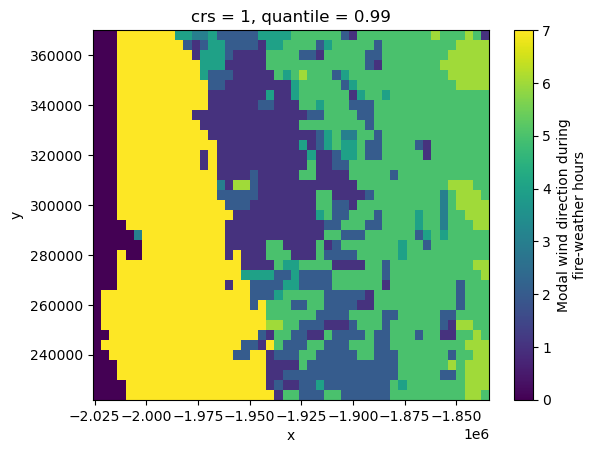

In [13]:
mode.wind_direction_mode.plot()

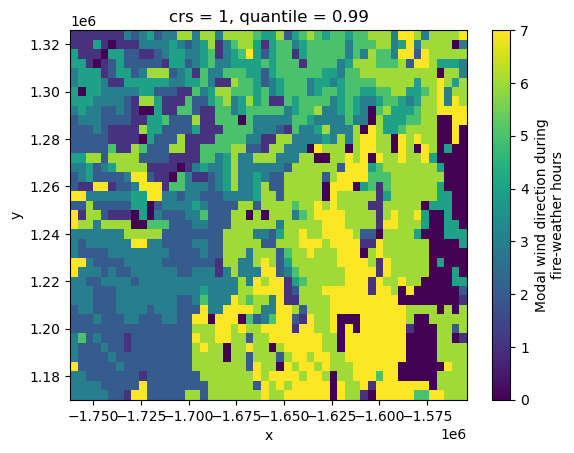

In [15]:
mode.wind_direction_mode.plot()

In [16]:
mode.to_zarr('s3://carbonplan-ocr/evaluation/washington_mode_fwi99p.zarr')

/opt/coiled/env/lib/python3.13/site-packages/zarr/api/asynchronous.py:233: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


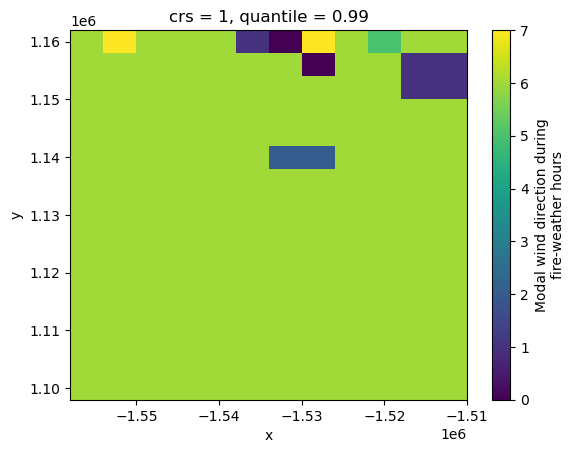

In [31]:
mode.wind_direction_mode.plot()

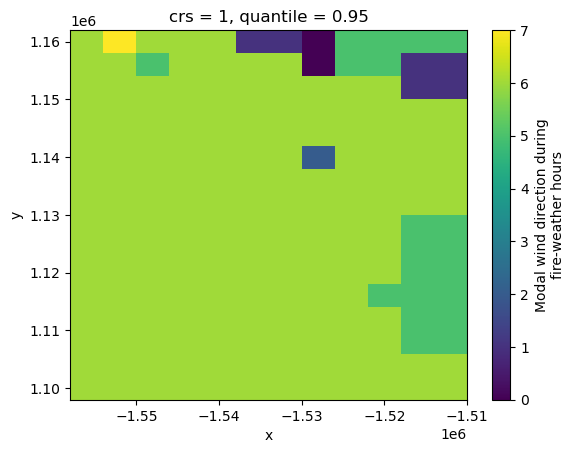

In [28]:
mode.wind_direction_mode.plot()